# Convolutional Neural Network using an Optimized Backpropagation Technique
It has been observed that training CNNs using vanilla backprogatation doesn't ensure good performance, since the objjective function is not close to the global minimum. Attempts to improve this can be made by ensuring that the gradient optimization technique tries to accurately model attempts at moving to the global minimum, despite continual changes to the gradients and the Network parameters.

This experiment attempts to demonstrate the working of two commonly used gradient descent optimizers during the backpropagation process.

We consider two optimizers, namely the:
* AdaDelta Optimizer
* RMSProp Optimizer

We shall compare the performance of these two well studied optimizers, to verify that the optimized backpropagation technique brings us very good validation results.

## Dataset Used
We will be using the **COIL-100** Dataset, consisting of exactly 100 images, each having 72 augmentations. This technique of data augmentation is necessary, since the original dataset of 100 immages is too small to generalize well.

The dataset resides in the `./dataset/coil-100` directory. We'll be using a generator to generate images and load it onto the main training loop.

In [0]:
import pandas as pd
import numpy as np
import glob
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Activation, Conv2D, AveragePooling2D, Flatten, Dropout, Reshape

from tensorflow.python.framework.ops import disable_eager_execution

# Disable eager execution
disable_eager_execution()

# Batch Generator
This is a function which generates images in a batch-wise manner, specified by the batch size. While this is not required in this problem, since we could load the entire dataset at once into memory, it is still a good practice to used similar functions, especially if your dataset cannot fit into memory.

This loads images from `directory`, and splits it into **training_images: validation_images** at the default ratio of `0.7:0.3`

We associate a label for each image, and the labels are also generated along with the images.

In [0]:
def generate_images(directory, batch_size, labels, shuffle, target_size, rescale=1./255, validation_split=0.3, fmt='png'):
    # Batch Generator -> Generates Numpy arrays from corresponding images after scaling
    if not isinstance(target_size, tuple):
        raise TypeError("Expected Tuple")
    assert validation_split <= 0.5
    
    data_path = pathlib.Path(directory)
    images = list(data_path.glob("*." + fmt))
    num_images = len(images)
    
    # A Label for each image
    print(labels.shape[0], num_images)
    assert num_images == labels.shape[0]

    idx = 0

    images = np.array(images)
    inds = np.arange(num_images)
    
    if shuffle:
        np.random.shuffle(inds)
        images, labels = images[inds], labels[inds]
        # random.shuffle(images)
    
    val_size = math.ceil(batch_size * (validation_split))
    train_size = batch_size - val_size
    
    while True:
        print("Loop running")
        image_batch_train = np.zeros((train_size,) + target_size, dtype='float') # target_size is already a tuple
        label_batch_train = np.zeros((train_size, labels.shape[1]))
        image_batch_val = np.zeros((val_size,) + target_size, dtype='float')
        label_batch_val = np.zeros((val_size, labels.shape[1]))
        for i in range(train_size):
            print("Train Batch:", i)
            if idx == num_images:
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_train[i] = image
            label_batch_train[i] = labels[idx]
            idx += 1
        for i in range(train_size, batch_size):
            print("Val Batch:", i)
            if idx == num_images:
                # Reset index and shuffle if we reach the end of the dataset
                idx = 0
                # random.shuffle(images)
                np.random.shuffle(inds)
                images, labels = images[inds], labels[inds]
            img = images[idx]
            image = np.asarray(Image.open(img)).reshape(target_size) * rescale
            image_batch_val[i - train_size] = image
            label_batch_val[i - train_size] = labels[idx]
            idx += 1
        # Yield a generator for both the training as well as the validation set of images
        yield image_batch_train, label_batch_train, image_batch_val, label_batch_val

* This helper function converts a numpy `ndarray` to a `PIL` image, for visualizing any output. While this is not directly used in the final experiment, we used this to verify that we were getting the correct outputs from our Network.

In [0]:
def numpy_to_img(normalized_img, scale):
    # The original array is normalized, so scale it again
    # RGB Mode expects uint8
    image = Image.fromarray((normalized_img * scale).astype('uint8'))
    return image

# One-Hot-Encoding Trick
For small datasets, the One Hot Encoding trick converts a scalar label into a vector. This is quite useful, since we can directly correlate the softmax output to the one-hot-vector, having the same dimensions. While this does not work for large datasets, we can take advantage of this technique quite clearly in our experiments.

* Originally, the labels were simply a number between 0 to 100. Since the number of images are small, we can directly convert them into a one-hot encoding format. This `one_hot_encoder()` function vectorizes a scalar label, and returns the one hot encoding of the labelled dataset.

In [0]:
def one_hot_encoder(label_dataset):
  """
    Takes a labelled dataset of the form: [ 0 0 0 ... 1 1 1 ... 100 100 100 ... ]
    and returns a one-hot encoding representation of the labelled data
  """
  unique_labels = np.unique(label_dataset)
  one_hot_labels = np.zeros((label_dataset.shape[0], unique_labels.shape[0]))
  label_dataset = np.repeat(label_dataset, unique_labels.shape[0]).reshape(-1, unique_labels.shape[0])
  one_hot_labels[np.where(label_dataset == unique_labels)] = 1
  return one_hot_labels

# Generating the Models

We have two models to compare: one using the Adadelta optimizer, and the other, using the RMSProp Optimizer.
The models are almost the same. The main structure difference is that the RMSProp has 50 weights for the second-last Dense layer, while the Adadelta has 100. Other that that, there are some hyperparameters specific to both the models.

Due to this, plus the fact that the RMSProp Optimizer uses a constant learning rate, we would generally expect the RMSProp model to converge faster than the Adadelta, although the performance wouldn't differ by much.

In [0]:
def generate_model(optimizer):
    if optimizer == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(
            learning_rate = 1.0, rho = 0.97, epsilon = 0, name = 'Adadelta')
        model = models.Sequential()
        model.add(layers.Conv2D(7, (3, 2), activation ='relu', input_shape = (128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(12, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(8, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(4, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(label_train.shape[1], activation = 'softmax'))
        model.compile(optimizer = optimizer,
                      loss = tf.keras.losses.CategoricalCrossentropy(),
                      metrics = ['accuracy'])
        return model
    elif optimizer == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(
            learning_rate = 0.001, rho = 0.9, momentum = 0.0, epsilon = 1e-07, name = 'RMSprop')
        model = models.Sequential()
        model.add(layers.Conv2D(7, (3, 2), activation ='relu', input_shape = (128, 128, 3)))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(12, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(8, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(4, (1, 1), activation = 'relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Flatten())
        model.add(layers.Dense(label_train.shape[1], activation = 'softmax'))
        model.compile(optimizer = optimizer,
                      loss = tf.keras.losses.CategoricalCrossentropy(),
                      metrics = ['accuracy'])
        return model
    else:
        raise ValueError("Only Adadelta and RMSprop optimizers are allowed")

# The Main Function


In [0]:
if __name__ == '__main__':
    data_dir = os.path.join(os.getcwd(), 'dataset', 'coil-100')
    data_path = pathlib.Path(data_dir)

    # Path to all images
    images = pathlib.Path(data_dir).glob("*.png")
    image_data = list(images)

    CLASS_LABELS = list([int(''.join(item.name.split('_')[0].lstrip('obj'))) for item in image_data])
    CLASS_LABELS = np.array((CLASS_LABELS))
    CLASS_LABELS = one_hot_encoder(CLASS_LABELS)
    
    # Define parameters for batch generation
    BATCH_SIZE = len(image_data)
    IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128
    NUM_CHANNELS = 3 # RGB Image has 3 channels

    # Use the batch generator. This outputs (train_images, val_images)
    gen = generate_images(directory=str(data_path), batch_size=BATCH_SIZE,
                            labels=CLASS_LABELS,
                            shuffle=True, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT, NUM_CHANNELS),
                            validation_split=0.3)

    # Example generation. This generates a single batch of training and validation images
    batch_train, label_train, batch_val, label_val = next(gen)

# Generate the Adadelta Model

In [12]:
model = generate_model('Adadelta')
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 127, 7)       133       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 7)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 63, 63, 12)        96        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 12)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 8)         104       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 4)        

# Fit the model on the Dataset

In [13]:
# Iterations = 1
history_iter1 = model.fit(batch_train, label_train, epochs = 800, batch_size = 5040,
                    validation_data = (batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/800
5040/5040 [==============================] - 0s 91us/sample - loss: 4.6286 - accuracy: 0.0062 - val_loss: 4.6191 - val_accuracy: 0.0046
Epoch 2/800
5040/5040 [==============================] - 0s 50us/sample - loss: 4.6195 - accuracy: 0.0067 - val_loss: 4.6129 - val_accuracy: 0.0046
Epoch 3/800
5040/5040 [==============================] - 0s 49us/sample - loss: 4.6125 - accuracy: 0.0073 - val_loss: 4.6082 - val_accuracy: 0.0046
Epoch 4/800
5040/5040 [==============================] - 0s 50us/sample - loss: 4.6071 - accuracy: 0.0069 - val_loss: 4.6044 - val_accuracy: 0.0056
Epoch 5/800
5040/5040 [==============================] - 0s 50us/sample - loss: 4.6027 - accuracy: 0.0069 - val_loss: 4.6011 - val_accuracy: 0.0051
Epoch 6/800
5040/5040 [==============================] - 0s 50us/sample - loss: 4.5989 - accuracy: 0.0069 - val_loss: 4.5980 - val_accuracy: 0.0046
Epoch 7/800
5040/5040 [==============================] - 0s 50us

In [14]:
# Iterations = 2
model = generate_model('Adadelta')
history_iter2 = model.fit(batch_train, label_train, epochs = 600, batch_size = 2520,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/600
5040/5040 [==============================] - 1s 191us/sample - loss: 4.6053 - accuracy: 0.0087 - val_loss: 4.6053 - val_accuracy: 0.0116
Epoch 2/600
5040/5040 [==============================] - 1s 165us/sample - loss: 4.6048 - accuracy: 0.0173 - val_loss: 4.6053 - val_accuracy: 0.0194
Epoch 3/600
5040/5040 [==============================] - 1s 162us/sample - loss: 4.6045 - accuracy: 0.0244 - val_loss: 4.6054 - val_accuracy: 0.0236
Epoch 4/600
5040/5040 [==============================] - 1s 163us/sample - loss: 4.6043 - accuracy: 0.0218 - val_loss: 4.6054 - val_accuracy: 0.0245
Epoch 5/600
5040/5040 [==============================] - 1s 164us/sample - loss: 4.6040 - accuracy: 0.0232 - val_loss: 4.6056 - val_accuracy: 0.0218
Epoch 6/600
5040/5040 [==============================] - 1s 164us/sample - loss: 4.6038 - accuracy: 0.0256 - val_loss: 4.6056 - val_accuracy: 0.0204
Epoch 7/600
5040/5040 [==============================] - 1

In [15]:
# Iterations = 3
model = generate_model('Adadelta')
history_iter3 = model.fit(batch_train, label_train, epochs = 400, batch_size = 1680,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/400
5040/5040 [==============================] - 1s 259us/sample - loss: 4.6159 - accuracy: 0.0024 - val_loss: 4.6107 - val_accuracy: 0.0014
Epoch 2/400
5040/5040 [==============================] - 1s 239us/sample - loss: 4.6040 - accuracy: 0.0020 - val_loss: 4.6016 - val_accuracy: 0.0014
Epoch 3/400
5040/5040 [==============================] - 1s 236us/sample - loss: 4.5956 - accuracy: 0.0020 - val_loss: 4.5942 - val_accuracy: 0.0028
Epoch 4/400
5040/5040 [==============================] - 1s 235us/sample - loss: 4.5874 - accuracy: 0.0065 - val_loss: 4.5856 - val_accuracy: 0.0079
Epoch 5/400
5040/5040 [==============================] - 1s 236us/sample - loss: 4.5773 - accuracy: 0.0109 - val_loss: 4.5746 - val_accuracy: 0.0088
Epoch 6/400
5040/5040 [==============================] - 1s 235us/sample - loss: 4.5635 - accuracy: 0.0133 - val_loss: 4.5573 - val_accuracy: 0.0116
Epoch 7/400
5040/5040 [==============================] - 1

In [16]:
# Iterations = 4
model = generate_model('Adadelta')
history_iter4 = model.fit(batch_train, label_train, epochs = 200, batch_size = 1260,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/200
5040/5040 [==============================] - 1s 286us/sample - loss: 4.6238 - accuracy: 0.0095 - val_loss: 4.6013 - val_accuracy: 0.0083
Epoch 2/200
5040/5040 [==============================] - 1s 255us/sample - loss: 4.5839 - accuracy: 0.0095 - val_loss: 4.5747 - val_accuracy: 0.0088
Epoch 3/200
5040/5040 [==============================] - 1s 255us/sample - loss: 4.5554 - accuracy: 0.0113 - val_loss: 4.5456 - val_accuracy: 0.0116
Epoch 4/200
5040/5040 [==============================] - 1s 255us/sample - loss: 4.5175 - accuracy: 0.0153 - val_loss: 4.4997 - val_accuracy: 0.0218
Epoch 5/200
5040/5040 [==============================] - 1s 255us/sample - loss: 4.4547 - accuracy: 0.0379 - val_loss: 4.4190 - val_accuracy: 0.0500
Epoch 6/200
5040/5040 [==============================] - 1s 255us/sample - loss: 4.3426 - accuracy: 0.0744 - val_loss: 4.2661 - val_accuracy: 0.0856
Epoch 7/200
5040/5040 [==============================] - 1

In [17]:
# Iterations = 5
model = generate_model('Adadelta')
history_iter5 = model.fit(batch_train, label_train, epochs = 200, batch_size = 1008,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/200
5040/5040 [==============================] - 1s 288us/sample - loss: 4.6044 - accuracy: 0.0173 - val_loss: 4.6040 - val_accuracy: 0.0167
Epoch 2/200
5040/5040 [==============================] - 1s 267us/sample - loss: 4.5998 - accuracy: 0.0242 - val_loss: 4.5992 - val_accuracy: 0.0208
Epoch 3/200
5040/5040 [==============================] - 1s 267us/sample - loss: 4.5926 - accuracy: 0.0327 - val_loss: 4.5903 - val_accuracy: 0.0343
Epoch 4/200
5040/5040 [==============================] - 1s 266us/sample - loss: 4.5784 - accuracy: 0.0427 - val_loss: 4.5698 - val_accuracy: 0.0472
Epoch 5/200
5040/5040 [==============================] - 1s 267us/sample - loss: 4.5497 - accuracy: 0.0538 - val_loss: 4.5286 - val_accuracy: 0.0370
Epoch 6/200
5040/5040 [==============================] - 1s 265us/sample - loss: 4.4863 - accuracy: 0.0536 - val_loss: 4.4394 - val_accuracy: 0.0662
Epoch 7/200
5040/5040 [==============================] - 1

# Plot results (Adadelta)

# Experiment 1 (`batch_size = 50`)

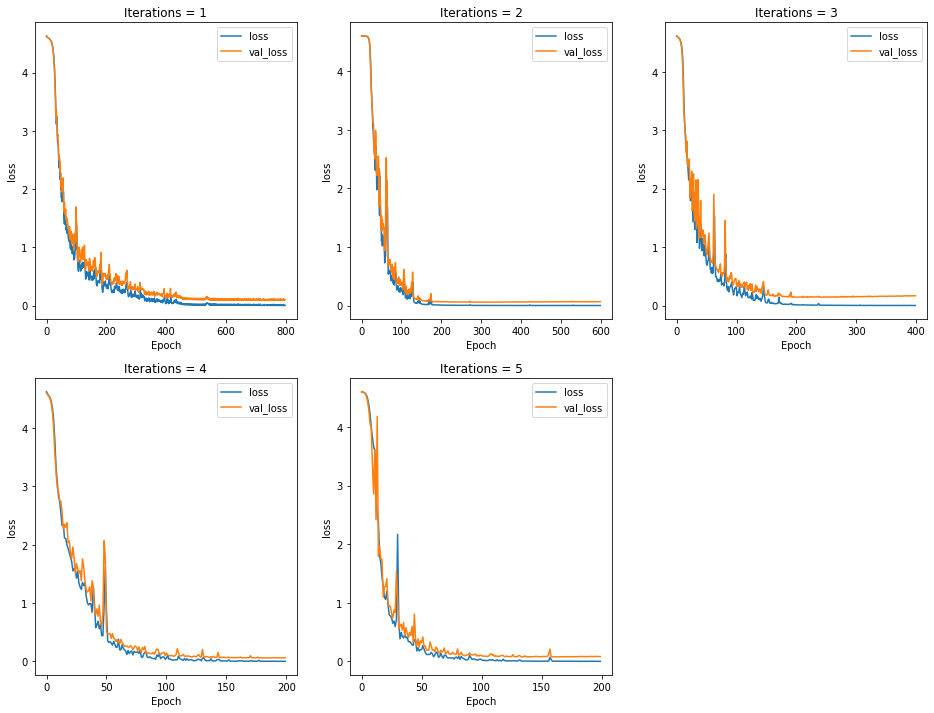

In [54]:
train_acc = np.zeros(5)
test_acc = np.zeros(5)
hist = np.array([history_iter1, history_iter2, history_iter3, 
                    history_iter4, history_iter5])

plt.figure(figsize = (16, 12))

for i in range(5):
    n = 231 + i
    plt.subplot(n)
    plt.plot(hist[i].history['loss'], label='loss')
    plt.plot(hist[i].history['val_loss'], label = 'val_loss')
    plt.title("Iterations = " + str(i + 1))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    train_acc[i] = hist[i].history['accuracy'][-1]
    test_acc[i] = hist[i].history['val_accuracy'][-1]

plt.show()

In [47]:
itrs = np.arange(1, 6, 1)
Accuracy_table = pd.DataFrame({'Iterations':itrs, 'Train Accuracy':train_acc, 'Test Accuracy':test_acc})
print(Accuracy_table)

   Iterations  Train Accuracy  Test Accuracy
0           1        0.999802       0.972222
1           2        1.000000       0.987500
2           3        1.000000       0.968982
3           4        0.999603       0.985185
4           5        1.000000       0.977778


In [0]:
# Generate the RMSProp Model

In [51]:
model = generate_model('RMSprop')
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 126, 127, 7)       133       
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 63, 63, 7)         0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 63, 63, 12)        96        
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 31, 31, 12)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 31, 31, 8)         104       
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 15, 15, 8)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 15, 15, 4)       

# Fit the Model using RMSProp Optimizer

In [52]:
#iterations = 1
history_iter1 = model.fit(batch_train, label_train, epochs = 800, batch_size = 5040,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/800
5040/5040 [==============================] - 1s 155us/sample - loss: 4.6034 - accuracy: 0.0028 - val_loss: 4.5908 - val_accuracy: 0.0074
Epoch 2/800
5040/5040 [==============================] - 0s 77us/sample - loss: 4.5895 - accuracy: 0.0062 - val_loss: 4.5787 - val_accuracy: 0.0125
Epoch 3/800
5040/5040 [==============================] - 0s 75us/sample - loss: 4.5765 - accuracy: 0.0115 - val_loss: 4.5661 - val_accuracy: 0.0125
Epoch 4/800
5040/5040 [==============================] - 0s 75us/sample - loss: 4.5632 - accuracy: 0.0127 - val_loss: 4.5529 - val_accuracy: 0.0144
Epoch 5/800
5040/5040 [==============================] - 0s 75us/sample - loss: 4.5494 - accuracy: 0.0131 - val_loss: 4.5400 - val_accuracy: 0.0148
Epoch 6/800
5040/5040 [==============================] - 0s 77us/sample - loss: 4.5355 - accuracy: 0.0125 - val_loss: 4.5253 - val_accuracy: 0.0153
Epoch 7/800
5040/5040 [==============================] - 0s 75u

In [57]:
#iterations = 2
model = generate_model('RMSprop')
history_iter2 = model.fit(batch_train, label_train, epochs = 600, batch_size = 2520,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/600
5040/5040 [==============================] - 2s 450us/sample - loss: 4.6019 - accuracy: 0.0111 - val_loss: 4.5947 - val_accuracy: 0.0088
Epoch 2/600
5040/5040 [==============================] - 1s 280us/sample - loss: 4.5824 - accuracy: 0.0111 - val_loss: 4.5810 - val_accuracy: 0.0097
Epoch 3/600
5040/5040 [==============================] - 1s 276us/sample - loss: 4.5666 - accuracy: 0.0115 - val_loss: 4.5667 - val_accuracy: 0.0116
Epoch 4/600
5040/5040 [==============================] - 1s 278us/sample - loss: 4.5503 - accuracy: 0.0143 - val_loss: 4.5514 - val_accuracy: 0.0102
Epoch 5/600
5040/5040 [==============================] - 1s 278us/sample - loss: 4.5329 - accuracy: 0.0137 - val_loss: 4.5351 - val_accuracy: 0.0102
Epoch 6/600
5040/5040 [==============================] - 1s 278us/sample - loss: 4.5149 - accuracy: 0.0137 - val_loss: 4.5179 - val_accuracy: 0.0167
Epoch 7/600
5040/5040 [==============================] - 1

In [58]:
#iterations = 3
model = generate_model('RMSprop')
history_iter3 = model.fit(batch_train, label_train, epochs = 400, batch_size = 1680,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/400
5040/5040 [==============================] - 3s 528us/sample - loss: 4.5946 - accuracy: 0.0109 - val_loss: 4.5640 - val_accuracy: 0.0162
Epoch 2/400
5040/5040 [==============================] - 2s 394us/sample - loss: 4.5461 - accuracy: 0.0190 - val_loss: 4.5216 - val_accuracy: 0.0278
Epoch 3/400
5040/5040 [==============================] - 2s 392us/sample - loss: 4.4971 - accuracy: 0.0319 - val_loss: 4.4722 - val_accuracy: 0.0421
Epoch 4/400
5040/5040 [==============================] - 2s 393us/sample - loss: 4.4383 - accuracy: 0.0482 - val_loss: 4.4083 - val_accuracy: 0.0556
Epoch 5/400
5040/5040 [==============================] - 2s 397us/sample - loss: 4.3683 - accuracy: 0.0613 - val_loss: 4.3380 - val_accuracy: 0.0736
Epoch 6/400
5040/5040 [==============================] - 2s 392us/sample - loss: 4.2921 - accuracy: 0.0829 - val_loss: 4.2622 - val_accuracy: 0.0917
Epoch 7/400
5040/5040 [==============================] - 2

In [60]:
#iterations = 4
model = generate_model('RMSprop')
history_iter4 = model.fit(batch_train, label_train, epochs = 200, batch_size = 1260,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/200
5040/5040 [==============================] - 3s 635us/sample - loss: 4.5927 - accuracy: 0.0145 - val_loss: 4.5669 - val_accuracy: 0.0148
Epoch 2/200
5040/5040 [==============================] - 2s 462us/sample - loss: 4.5470 - accuracy: 0.0194 - val_loss: 4.5191 - val_accuracy: 0.0204
Epoch 3/200
5040/5040 [==============================] - 2s 428us/sample - loss: 4.4922 - accuracy: 0.0188 - val_loss: 4.4645 - val_accuracy: 0.0194
Epoch 4/200
5040/5040 [==============================] - 2s 428us/sample - loss: 4.4299 - accuracy: 0.0276 - val_loss: 4.3998 - val_accuracy: 0.0222
Epoch 5/200
5040/5040 [==============================] - 2s 428us/sample - loss: 4.3580 - accuracy: 0.0353 - val_loss: 4.3275 - val_accuracy: 0.0361
Epoch 6/200
5040/5040 [==============================] - 2s 426us/sample - loss: 4.2775 - accuracy: 0.0433 - val_loss: 4.2472 - val_accuracy: 0.0384
Epoch 7/200
5040/5040 [==============================] - 2

In [62]:
#iterations = 5
model = generate_model('RMSprop')
history_iter5 = model.fit(batch_train, label_train, epochs = 200, batch_size = 1008,
                    validation_data=(batch_val, label_val))

Train on 5040 samples, validate on 2160 samples
Epoch 1/200
5040/5040 [==============================] - 3s 605us/sample - loss: 4.5933 - accuracy: 0.0111 - val_loss: 4.5788 - val_accuracy: 0.0213
Epoch 2/200
5040/5040 [==============================] - 2s 454us/sample - loss: 4.5542 - accuracy: 0.0337 - val_loss: 4.5376 - val_accuracy: 0.0296
Epoch 3/200
5040/5040 [==============================] - 2s 457us/sample - loss: 4.5001 - accuracy: 0.0516 - val_loss: 4.4804 - val_accuracy: 0.0444
Epoch 4/200
5040/5040 [==============================] - 2s 456us/sample - loss: 4.4324 - accuracy: 0.0663 - val_loss: 4.4141 - val_accuracy: 0.0593
Epoch 5/200
5040/5040 [==============================] - 2s 456us/sample - loss: 4.3540 - accuracy: 0.0857 - val_loss: 4.3332 - val_accuracy: 0.0866
Epoch 6/200
5040/5040 [==============================] - 2s 459us/sample - loss: 4.2654 - accuracy: 0.1071 - val_loss: 4.2440 - val_accuracy: 0.1190
Epoch 7/200
5040/5040 [==============================] - 2

# Plot Results (RMSProp)

In [0]:
train_acc = np.zeros(6)
test_acc = np.zeros(6)
hist = np.array([history_iter1, history_iter2, history_iter3, 
                    history_iter4, history_iter5])

plt.figure(figsize = (16, 12))

for i in range(5):
    n = 231 + i
    plt.subplot(n)
    plt.plot(hist[i].history['loss'], label='loss')
    plt.plot(hist[i].history['val_loss'], label = 'val_loss')
    plt.title("Iterations = " + str(i + 1))
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    train_acc[i] = hist[i].history['accuracy'][-1]
    test_acc[i] = hist[i].history['val_accuracy'][-1]

plt.show()

In [53]:
itrs = np.arange(1, 6, 1)
Accuracy_table = pd.DataFrame({'Iterations':itrs, 'Train Accuracy':train_acc, 'Test Accuracy':test_acc})
print(Accuracy_table)

   Iterations  Train Accuracy  Test Accuracy
0           1          0.9984         0.9750
1           2          0.9976         0.9569
2           3          0.9990         0.9782
3           4          1.0000         0.9773
4           5          0.9960         0.9778


# Conclusion

As you can observe the results are computed for small CNN Model has better accuracies for Adadelta Optimization Method than RMSProp Optimization method. This is due to the fact that RMSProp stores only histories of gradient of error function to dynamically adapt the learning rate however, the Adadelta stores history of change in weights along with history of gradients.
The accuracies of model are limited and not on par with paper due to the small size of the CNN model. The full and partial batch (i.e. for itertions in range(1:5)) could only be done on be accomplished through this CNN Model with available computational resources.
For higher accuracy model that has batch size of 20 please open file cnn_project.ipynb/ cnn.project.py. The presentation is based on this .ipynb file (i.e. cnn_project.ipynb)

Thanks&Regards